In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

from robustbench.utils import load_model
# Load a model from the model zoo
model = load_model(model_name='Gowal2021Improving_R18_ddpm_100m', dataset='cifar10', threat_model='Linf',  model_dir="models")


In [3]:
## get data

In [4]:
import torchvision.datasets as datasets
from torchvision import transforms
import torch
from src.utils.data_utils import create_loaders


transf = transforms.Compose([lambda x: x/1])
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

# cifar_trainset = datasets.CIFAR10(root='data', train=True, download=True, transform=None)
# cifar_testset = datasets.CIFAR10(root='data', train=False, download=True, transform=None)





batch_size = 20
n_workers = 1
data_loader = create_loaders("./data", task_config="CIFAR10",
                             batch_size=batch_size,
                             transform=transf,
                             random_state=0,
                             n_workers=n_workers)


Files already downloaded and verified


In [21]:
images, labels = next(iter(data_loader))
images, labels = images.to(device), labels.to(device)

In [22]:
from adv_lib.attacks import fmn
from tracking import PyTorchModelTrackerSetup
from logging_ import Logger
from tqdm import tqdm
import sys

logger = Logger()
logger.setup(attack_name="fmn", model_name="Gowal2021Improving_R18_ddpm_100m", hyperparams="default")
tracked_model = PyTorchModelTrackerSetup(model, loss_f="CE", logger=logger)  # pytorch model


norm = float("inf")  # will use Linf norm
n_samples = 100

for b, (images, labels) in enumerate(tqdm(data_loader, total=n_samples//batch_size)):

    if b*batch_size >= n_samples:
        break

    tracked_model.setup(images, labels)
    # do attack on selected examples
    results = fmn(tracked_model, images, labels, norm, steps=200)
    tracked_model.log()
    #print(logger.loss_progress)

    #print(sum(map(lambda x: sys.getsizeof(x.storage()), logger.loss_progress)))
#     print(sys.getsizeof(logger.norm_progress.storage()))


100%|██████████| 5/5 [15:03<00:00, 180.74s/it]


In [23]:
results.shape

torch.Size([20, 3, 32, 32])

In [24]:
[x.mean() for x in logger.loss_progress]

[tensor(0.3408),
 tensor(0.4849),
 tensor(0.6915),
 tensor(0.9670),
 tensor(1.2588),
 tensor(1.5198),
 tensor(1.7326),
 tensor(1.8928),
 tensor(2.0097),
 tensor(2.0756),
 tensor(2.1102),
 tensor(2.1141),
 tensor(2.0888),
 tensor(2.0447),
 tensor(1.9862),
 tensor(1.9163),
 tensor(1.8412),
 tensor(1.7616),
 tensor(1.6946),
 tensor(1.6173),
 tensor(1.5533),
 tensor(1.4849),
 tensor(1.4265),
 tensor(1.3813),
 tensor(1.3302),
 tensor(1.2841),
 tensor(1.2364),
 tensor(1.1959),
 tensor(1.1629),
 tensor(1.1225),
 tensor(1.1009),
 tensor(1.0618),
 tensor(1.0286),
 tensor(1.0168),
 tensor(0.9864),
 tensor(0.9796),
 tensor(0.9559),
 tensor(0.9575),
 tensor(0.9389),
 tensor(0.9346),
 tensor(0.9305),
 tensor(0.9263),
 tensor(0.9367),
 tensor(0.9259),
 tensor(0.9423),
 tensor(0.9222),
 tensor(0.9442),
 tensor(0.9163),
 tensor(0.9358),
 tensor(0.9193),
 tensor(0.9382),
 tensor(0.9200),
 tensor(0.9385),
 tensor(0.9259),
 tensor(0.9420),
 tensor(0.9259),
 tensor(0.9323),
 tensor(0.9221),
 tensor(0.9309

In [25]:
model(results).argmax(dim=-1)

tensor([6, 5, 3, 4, 1, 8, 3, 2, 3, 2, 6, 6, 2, 0, 9, 6, 2, 3, 3, 1])

In [26]:
model(images).argmax(dim=-1)

tensor([8, 0, 0, 0, 7, 6, 5, 6, 1, 7, 7, 9, 1, 2, 7, 4, 8, 0, 3, 1])

In [27]:
labels

tensor([8, 0, 0, 0, 7, 6, 5, 6, 1, 9, 7, 9, 1, 2, 7, 4, 8, 0, 6, 1])

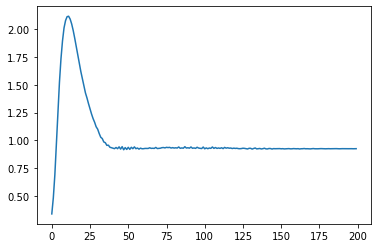

In [28]:
logger.plot_progress(kind="loss")

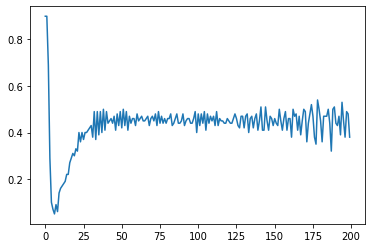

In [29]:
logger.plot_progress(kind="acc")

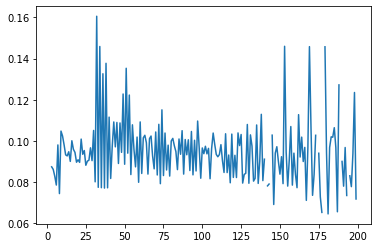

In [30]:
logger.plot_QD()

In [31]:
logger.save_all(force=True)

In [5]:
from sweeping import Sweeper

In [18]:
sweeper = Sweeper.from_jsonfile("config.json")

In [19]:
sweeper.sweep()

fmn
Files already downloaded and verified


100%|██████████| 5/5 [06:34<00:00, 78.87s/it]


Done: 1/8
alma
Files already downloaded and verified


  0%|          | 0/5 [00:00<?, ?it/s]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/home/michal/adversarial-ml-comparison/adv_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_31271/868312607.py", line 1, in <cell line: 1>
    sweeper.sweep()
  File "/home/michal/adversarial-ml-comparison/src/sweeping.py", line 55, in sweep
    self.run(n_samples=n_samples, **row.to_dict())
  File "/home/michal/adversarial-ml-comparison/src/sweeping.py", line 105, in run
    results = attack_f(tracked_model, images, labels, numeric_norm, **hyperparams)
TypeError: alma() got an unexpected keyword argument 'steps'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/michal/adversarial-ml-comparison/adv_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 1982, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/mic